In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import random

In [2]:

times_gen = 2
num_points = 24

arrays_path = "/root/autodl-tmp/Mathews_arrays.npz"

In [3]:

loaded_arrays = np.load(arrays_path, allow_pickle=True)

image_array2 = loaded_arrays["image_array"]
landmark_array2 = loaded_arrays["landmark_array"]
filename_array2 = loaded_arrays["filename_array"]

In [4]:

image_array2 = np.expand_dims(image_array2, axis=-1)
image_array2.shape

(202, 800, 800, 1)

In [5]:

checked_arrays = np.load("/root/autodl-tmp/checked_filename_case_mathews.npz", allow_pickle=True)
checked_filename_list = checked_arrays["checked_filename_list"]

In [6]:
remove_list = []
for ii in range(len(filename_array2)):
    # if ii>=452:
    #     continue
    if filename_array2[ii] in checked_filename_list: 
        continue
    else:
        print("remove:",filename_array2[ii])
        remove_list.append(ii)

remove: UOPMathews_002_1_6_WithLabel.png
remove: UOPMathews_003_1_4_WithLabel.png
remove: UOPMathews_030_1_8_WithLabel.png


In [7]:
remove_list

[10, 16, 169]

In [8]:
filename_array2 = np.delete(filename_array2, [remove_list], axis=0)
image_array2 = np.delete(image_array2, [remove_list], axis=0)
landmark_array2 = np.delete(landmark_array2, [remove_list], axis=0)

In [9]:
image_array2.shape

(199, 800, 800, 1)

In [10]:

def adjust_brightness_contrast(image_array, brightness=1.0, contrast=1.0):

    image = Image.fromarray((image_array * 255).astype('uint8'), 'L')
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(brightness)
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(contrast)

    return np.array(image).astype('float32') / 255



In [11]:


data = np.load('/root/autodl-tmp/all_adjusted_images.npz')


adjusted_images = data['images']

In [12]:
adjusted_images.shape

(199, 800, 800, 1)

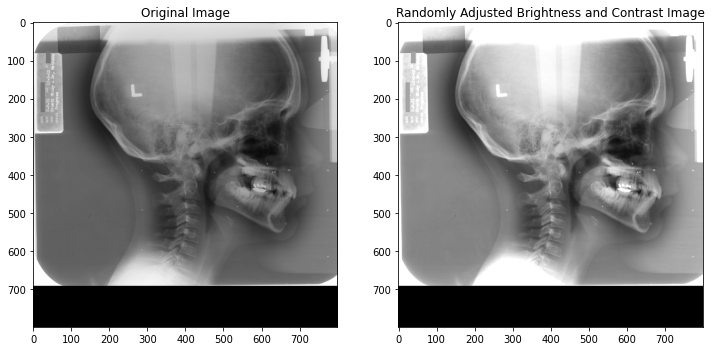

In [13]:

fig, axes = plt.subplots(1, 2, figsize=(12, 10))
num = 9
axes[0].imshow(image_array2[num, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(adjusted_images[num, :, :, 0], cmap='gray')
axes[1].set_title('Randomly Adjusted Brightness and Contrast Image')
plt.show()


In [14]:

augmented_landmarks = np.concatenate([landmark_array2, landmark_array2], axis=0)

augmented_images = np.concatenate([image_array2, adjusted_images], axis=0) 

enhanced_filenames = [f"enhanced_{name}" for name in filename_array2] 
augmented_filenames = np.concatenate([filename_array2, enhanced_filenames], axis=0)

print("Total images count:", augmented_images.shape[0])  
print("Total landmarks count:", augmented_landmarks.shape[0])
print("Total filenames count:", len(augmented_filenames))


print("Sample original filenames:", filename_array2[:5])  
print("Sample enhanced filenames:", enhanced_filenames[:5]) 

Total images count: 398
Total landmarks count: 398
Total filenames count: 398
Sample original filenames: ['UOPMathews_001_1_2_WithLabel.png' 'UOPMathews_001_1_3_WithLabel.png'
 'UOPMathews_001_1_4_WithLabel.png' 'UOPMathews_001_1_5_WithLabel.png'
 'UOPMathews_001_1_6_WithLabel.png']
Sample enhanced filenames: ['enhanced_UOPMathews_001_1_2_WithLabel.png', 'enhanced_UOPMathews_001_1_3_WithLabel.png', 'enhanced_UOPMathews_001_1_4_WithLabel.png', 'enhanced_UOPMathews_001_1_5_WithLabel.png', 'enhanced_UOPMathews_001_1_6_WithLabel.png']


In [15]:
filename_array2  = augmented_filenames
image_array2 = augmented_images
landmark_array2 = augmented_landmarks

In [16]:
landmark_array2.shape

(398, 48)

In [19]:

normalized_landmarks = landmark_array2 / 800.0
landmark_array2 = normalized_landmarks

print("Normalized landmarks shape:", normalized_landmarks.shape)
print("Sample data from normalized landmarks:", normalized_landmarks[0])  

Normalized landmarks shape: (398, 48)
Sample data from normalized landmarks: [0.6125     0.85375    0.53128798 0.79743439 0.83369302 0.84278488
 0.8399154  0.82878626 0.80561982 0.80324413 0.80297479 0.77810083
 0.74703039 0.7289779  0.72685256 0.6874154  0.62769164 0.61568888
 0.55610152 0.68025725 0.52928522 0.62169026 0.85345994 0.56243439
 0.33125    0.3125     0.39052831 0.41174724 0.52458391 0.48197341
 0.54857217 0.54340297 0.61627244 0.59433184 0.64262604 0.66333218
 0.46628453 0.52300069 0.52584772 0.57483943 0.57847548 0.57069233
 0.39061119 0.469798   0.45102555 0.57458391 0.46404696 0.42464779]


In [40]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(
    image_array2, landmark_array2, filename_array2, test_size=0.2, random_state=42)

In [45]:

np.savez('/root/autodl-tmp/final_dataset_forCNN.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, filenames_train=filenames_train, filenames_test=filenames_test)

In [46]:

data = np.load('/root/autodl-tmp/final_dataset_forCNN.npz')

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
filenames_train = data['filenames_train']
filenames_test = data['filenames_test']

print("Loaded training data shape:", X_train.shape)
print("Loaded test data shape:", X_test.shape)


Loaded training data shape: (318, 800, 800, 1)
Loaded test data shape: (80, 800, 800, 1)


In [47]:

mixed_prec_flag = 0

if mixed_prec_flag == 1:
    import os
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.optimizers import Adam
import tensorflow as tf
# from tensorflow.keras.callbacks import EarlyStopping

if mixed_prec_flag == 1:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(800, 800, 1)))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))

model.add(MaxPooling2D((2, 2)))


model.add(Flatten())

model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))

if mixed_prec_flag == 1:
    model.add(Dense(num_points*2, dtype='float32'))  
else:
    model.add(Dense(num_points*2))


sgd = SGD(learning_rate=0.001, momentum=0.9)

model.compile(optimizer=sgd, loss='mse', metrics=['mae'])

# model.compile(optimizer='adam', loss='mse', metrics=['mae'])  
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 798, 798, 64)      640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 399, 399, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 397, 397, 128)     73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 198, 198, 128)    0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 196, 196, 256)     295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 98, 98, 256)     

In [92]:

history = model.fit(X_train, y_train, epochs=300, batch_size=5, validation_split=0.2)

Epoch 1/300
51/51 [==============================] - 3s 62ms/step - loss: 7.2666e-06 - mae: 0.0020 - val_loss: 4.3331e-05 - val_mae: 0.0050
Epoch 2/300
51/51 [==============================] - 3s 59ms/step - loss: 7.0561e-06 - mae: 0.0020 - val_loss: 4.3230e-05 - val_mae: 0.0050
Epoch 3/300
51/51 [==============================] - 3s 59ms/step - loss: 7.1349e-06 - mae: 0.0020 - val_loss: 4.3358e-05 - val_mae: 0.0050
Epoch 4/300
51/51 [==============================] - 3s 59ms/step - loss: 7.1324e-06 - mae: 0.0020 - val_loss: 4.3303e-05 - val_mae: 0.0050
Epoch 5/300
51/51 [==============================] - 3s 59ms/step - loss: 7.1332e-06 - mae: 0.0020 - val_loss: 4.3254e-05 - val_mae: 0.0050
Epoch 6/300
51/51 [==============================] - 3s 59ms/step - loss: 7.0919e-06 - mae: 0.0020 - val_loss: 4.3461e-05 - val_mae: 0.0050
Epoch 7/300
51/51 [==============================] - 3s 59ms/step - loss: 7.1449e-06 - mae: 0.0020 - val_loss: 4.3156e-05 - val_mae: 0.0050
Epoch 8/300
51/51 [=

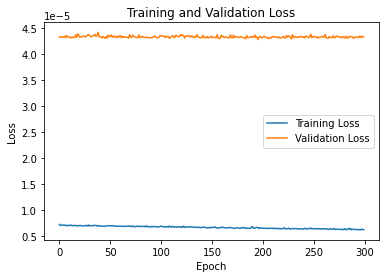

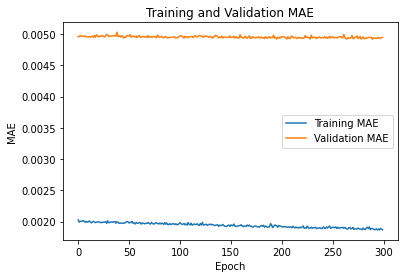

In [93]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [102]:

# model.save('/root/autodl-tmp/0607_4p58MAE_SGD_based0506_model.h5')

from keras.models import load_model


# model = load_model('/root/autodl-tmp/best0506_skull_model.h5')

# y_test= y_test/800.0

In [ ]:



batch_size = 5 
test_loss, test_mae = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f"test_loss: {test_loss}, test_mae: {test_mae}")


test_mae_original = test_mae * 800
test_loss_original = test_loss * 800 * 800
print(f"test_loss_original: {test_loss_original}, test_mae_original: {test_mae_original}")

In [95]:
y_test

array([[0.5875    , 0.82      , 0.51270357, ..., 0.595525  , 0.46938571,
        0.44251429],
       [0.6075    , 0.84125   , 0.5423293 , ..., 0.59152383, 0.46248222,
        0.43706081],
       [0.58      , 0.80625   , 0.5194434 , ..., 0.57137744, 0.48563906,
        0.43999625],
       ...,
       [0.5975    , 0.82875   , 0.52267235, ..., 0.59665276, 0.47001089,
        0.42840167],
       [0.605     , 0.86375   , 0.51303774, ..., 0.61544025, 0.48456447,
        0.42482547],
       [0.58875   , 0.82875   , 0.5170051 , ..., 0.59911735, 0.48238946,
        0.4205051 ]])

In [96]:

y_test = y_test * 800.0

In [ ]:

batch_size = 5 
predictions = model.predict(X_test, batch_size=batch_size)

predictions = predictions * 800

print('The predicted coordinates of the first test sample:', predictions[0])

In [98]:
csv_file_path = "dataset_prediction_labels.csv" 
import pandas as pd
df = pd.DataFrame(
    {
        "dataset_prediction_labels": predictions.tolist()
    }
)
df.to_csv(csv_file_path, index=False)

csv_file_path = "dataset_ground_truth_labels.csv" 
df = pd.DataFrame(
    {
        "dataset_ground_truth_labels": y_test.tolist()
    }
)
df.to_csv(csv_file_path, index=False)

csv_file_path = "dataset_filename.csv"
df = pd.DataFrame(
    {
        "dataset_filename": filenames_test.tolist()
    }
)
df.to_csv(csv_file_path, index=False)

UOPMathews_007_1_2_WithLabel.png


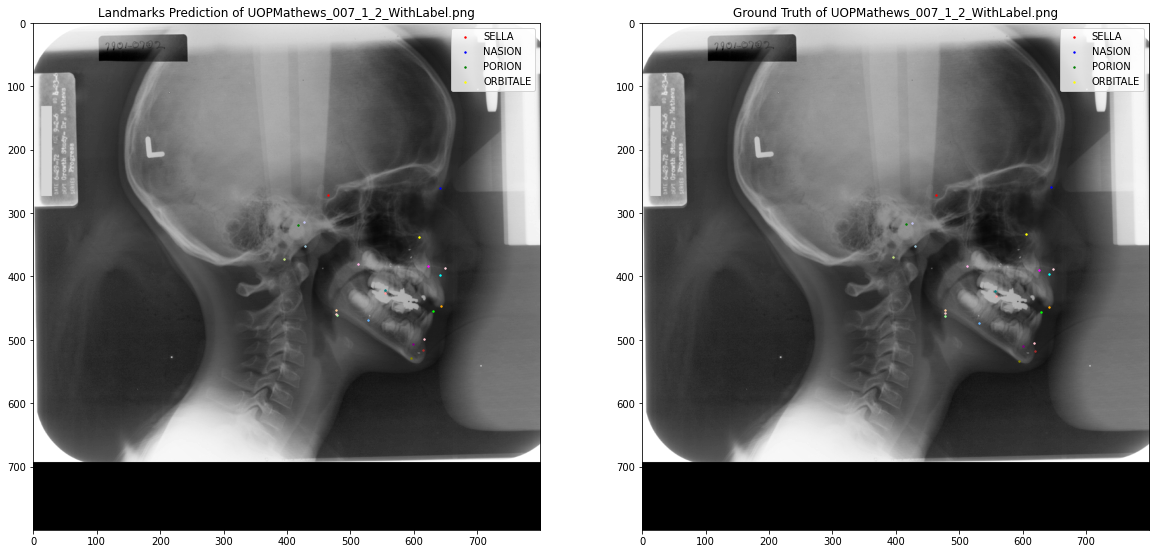

In [99]:

import matplotlib.pyplot as plt
import numpy as np


sample_index = 2
first_image = np.squeeze(X_test[sample_index]) 
second_image = np.squeeze(y_test[sample_index]) # ground truth

predicted_coords = predictions[sample_index]

x_points = predictions[sample_index][:num_points] 
y_points = predictions[sample_index][num_points:]  
x_points2 = second_image[:num_points] 
y_points2 = second_image[num_points:] 

print(filenames_test[sample_index])

bright_colors = ['red', 'blue', 'green', 'yellow'] + \
                ['magenta', 'cyan', 'orange', 'lime', 'pink', 'purple', 'brown', 'olive', 'gray', 'teal'] + \
                ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0','#ffb3e6', '#c4e17f', '#f7caca', '#ffd1dc', '#9dc6d8', 'lime']


assert len(bright_colors) >= num_points


fig = plt.figure(figsize=(20, 10))


plt.subplot(1, 2, 1)
plt.imshow(first_image, cmap='gray') 

for i in range(num_points):
    if i < 4:
        plt.scatter(x_points[i], y_points[i], s=2, color=bright_colors[i], label=['SELLA', 'NASION', 'PORION', 'ORBITALE'][i])
    else:
        plt.scatter(x_points[i], y_points[i], s=2, color=bright_colors[i])
plt.legend()
plt.title("Landmarks Prediction of "+ filenames_test[sample_index])


plt.subplot(1, 2, 2)
plt.imshow(first_image, cmap='gray') 

for i in range(num_points):
    if i < 4:
        plt.scatter(x_points2[i], y_points2[i], s=2, color=bright_colors[i], label=['SELLA', 'NASION', 'PORION', 'ORBITALE'][i])
    else:
        plt.scatter(x_points2[i], y_points2[i], s=2, color=bright_colors[i])
plt.legend()
plt.title("Ground Truth of "+ filenames_test[sample_index])


plt.show()


In [1]:
# load model
from keras.models import load_model
model = load_model('/root/autodl-fs/skull_model.h5')

2024-05-06 21:01:12.522576: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 21:01:14.398254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 21:01:15.157111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46720 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:d5:00.0, compute capability: 8.6


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
    img = img / 255.0  
    img = np.expand_dims(img, axis=-1) 
    img = np.expand_dims(img, axis=0) 
    return img

def predict_landmarks(model, processed_image):
    predictions = model.predict(processed_image)
    return predictions
    # return predictions.reshape(-1, 2)  # Assuming the model outputs flat (x, y) pairs

def display_image_and_landmarks(image, landmarks):
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0] * 800, landmarks[:, 1] * 800, c='red', s=10) 
    plt.show()
  
# preprocess image
image = preprocess_image('/root/autodl-fs/UOPMathews_001_1_5_NoLabel.png')

# apple model & get predicted landmarks
landmarks = predict_landmarks(model, image)

# re normol
predictions = landmarks * 800

1/1 [==============================] - 0s 26ms/step


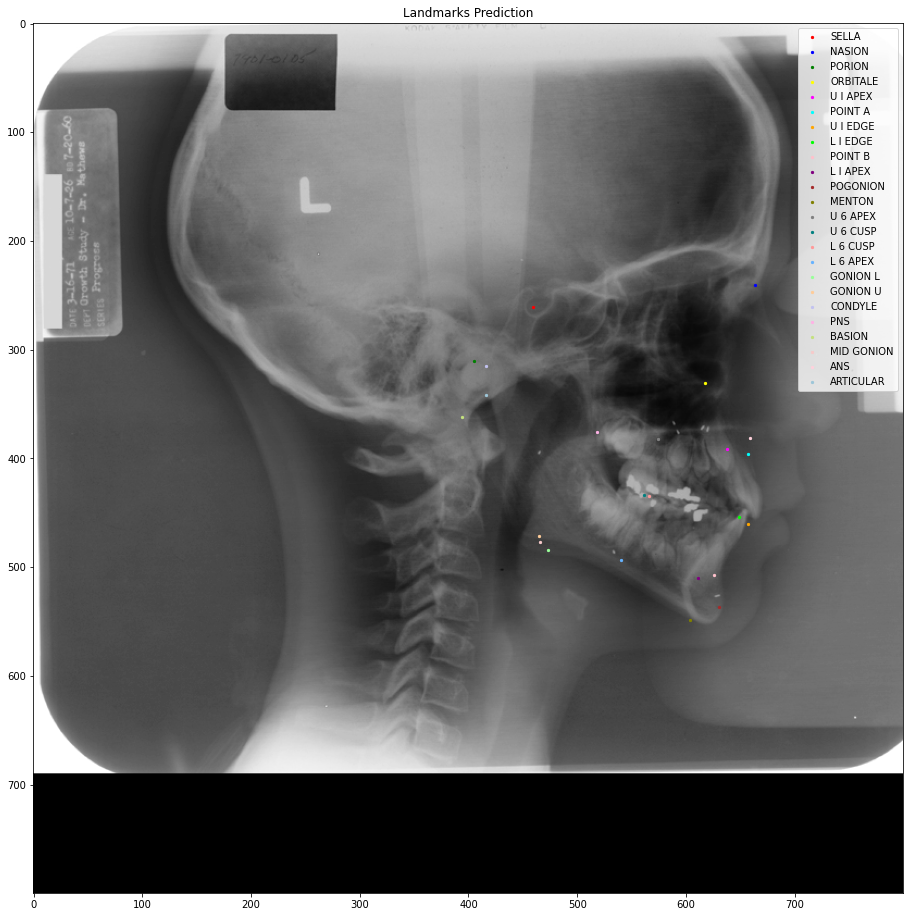

In [9]:
# plot predicted landmarks
import matplotlib.pyplot as plt
import numpy as np

num_points = 24
first_image = np.squeeze(image)  
predicted_coords = predictions

x_points = predictions[0][0:24]  
y_points = predictions[0][24:] 

bright_colors = ['red', 'blue', 'green', 'yellow'] + \
                ['magenta', 'cyan', 'orange', 'lime', 'pink', 'purple', 'brown', 'olive', 'gray', 'teal'] + \
                ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0','#ffb3e6', '#c4e17f', '#f7caca', '#ffd1dc', '#9dc6d8', 'lime']

landmark_names = [
    'SELLA', 'NASION', 'PORION', 'ORBITALE', 
    'U I APEX', 'POINT A', 'U I EDGE', 'L I EDGE', 
    'POINT B', 'L I APEX', 'POGONION', 'MENTON', 
    'U 6 APEX', 'U 6 CUSP', 'L 6 CUSP', 'L 6 APEX', 
    'GONION L', 'GONION U', 'CONDYLE', 'PNS', 
    'BASION', 'MID GONION', 'ANS', 'ARTICULAR'
]


assert len(bright_colors) >= num_points


fig = plt.figure(figsize=(18, 16))

plt.imshow(first_image, cmap='gray') 

for i in range(num_points):
    plt.scatter(x_points[i], y_points[i], s=5, color=bright_colors[i], label=landmark_names[i])
    # if i < 4:
    #     plt.scatter(x_points[i], y_points[i], s=2, color=bright_colors[i], label=['SELLA', 'NASION', 'PORION', 'ORBITALE'][i])
    # else:
    #     plt.scatter(x_points[i], y_points[i], s=2, color=bright_colors[i])
plt.legend()
plt.title("Landmarks Prediction")
plt.show()